# ARMA Model
---

## Autoregressive process of order p  (AR(p)) is defined as

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t$

## Moving average process of order q  (MA(q)) is defined:

$y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots +\theta_q \epsilon_{t-q}$

## ARMA(p,q) is defined as:

$y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots +\theta_q \epsilon_{t-q} + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t$

In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Lets simulate a ARMA(1,1) process:

$y_t=1+0.9 \epsilon_{t-1} +1+ 0.33y_{t-1}$

In [6]:
ar1 = np.array([1, 0.33])
ma1 = np.array([1, 0.9])
simulated_ARMA_data = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

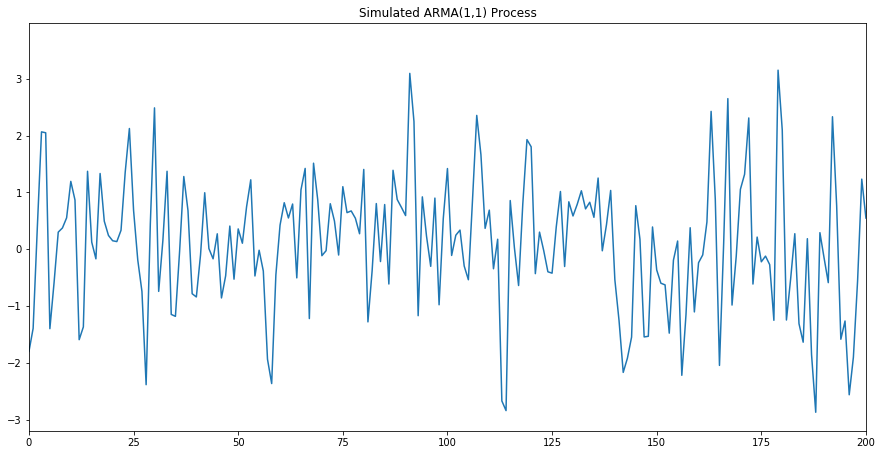

In [7]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(simulated_ARMA_data)
plt.title("Simulated ARMA(1,1) Process")
plt.xlim([0, 200])
plt.show()

# ACF and PACF
(Auto-corrlaion and Patial Auto-correlation)

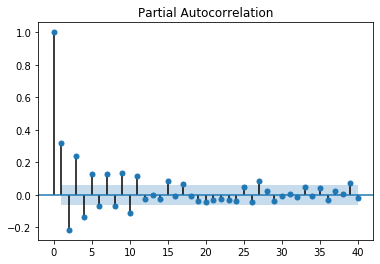

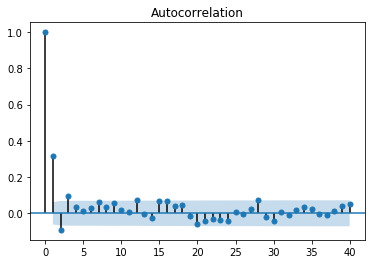

In [9]:
plot_pacf(simulated_ARMA_data,lags=40);
plot_acf(simulated_ARMA_data,lags=40);


+ We cannot infer the order of the ARMA process by looking at these plots. 
+ we can see some sinusoidal shape in both ACF and PACF functions


# Lets simulate a ARMA(2,2) process
$y_t = 1 + 0.9\epsilon_{t-1} + 0.3 \epsilon_{t-2} +1 + 0.33 y_{t-1} + 0.5 y_{t-2}$

In [14]:
ar2 = np.array([1, 0.33, 0.5])
ma2 = np.array([1, 0.9, 0.3])
simulated_ARMA2_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)

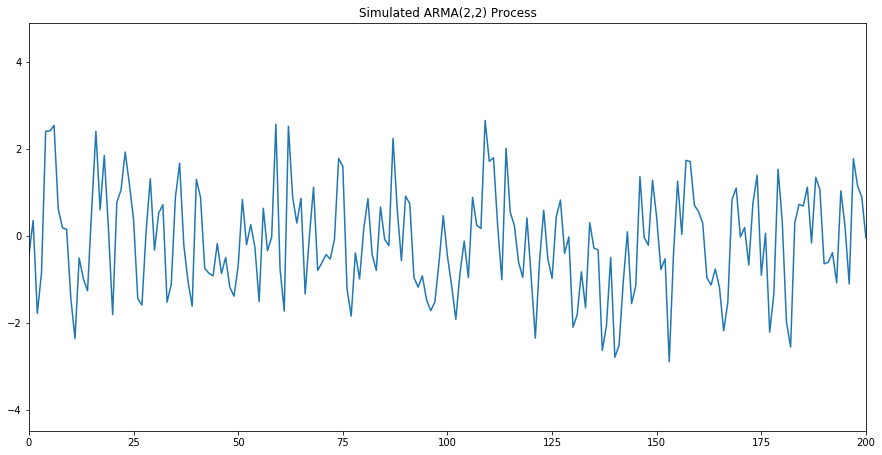

In [15]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(simulated_ARMA2_data)
plt.title("Simulated ARMA(2,2) Process")
plt.xlim([0, 200])
plt.show()


# ACF and PACF

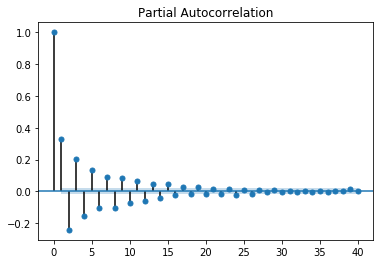

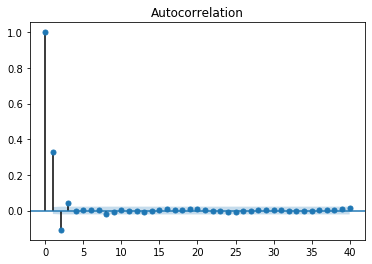

In [16]:
plot_pacf(simulated_ARMA2_data,lags=40);
plot_acf(simulated_ARMA2_data,lags=40);

# ARIMA Model

## ARIMA stands for AutoRegressive Integrated Moving Average.


This model is the combination of **autoregression**, a **moving average** model and **differencing**.  Differencing is useful to remove the trend in a time series and make it stationary. It simply involves subtracting a point a $t-1$ from time $t$. Realize that you will, therefore, lose the first data point in a time series if you apply differencing once. **ARIMA(p,d,q)**  requires three parameters:

+ p: the order of the autoregressive process
+ d: the degree of differencing (number of times it was differenced)
+ q: the order of the moving average process

$y_t' = c+ \phi_1y_{t-1}' + \cdots + \phi_p y_{t-1}'+  \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots +\theta_q \epsilon_{t-q} $


For an **ARIMA(p,d,0)** process:

+ the ACF is exponentially decaying or sinusoidal
+ the PACF has a significant spike at lag p but none after

For an **ARIMA(0,d,q)** process:
+ the PACF is exponentially decaying or sinusoidal
+ the ACF has a significant spike at lag q but none after

# Modeling

In [22]:
data = pd.read_csv('../datasets/covid_epidemiology.csv',index_col=0)
data.index=[str(x).zfill(5) for x in data.index]
data.head()

,65yrs,minority,black,hispanic,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,poverty,...,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20
01001,8924,13262,11237,1671,55869,0.159731,0.237377,0.201131,0.029909,7587,...,2716,2735,2751,2780,2818,2873,2893,2945,2979,3005
01003,46830,28036,19593,10534,223234,0.209780,0.125590,0.087769,0.047188,21069,...,8603,8733,8820,8890,9051,9163,9341,9501,9626,9728
01005,4861,12552,11906,1117,24686,0.196913,0.508466,0.482298,0.045248,6788,...,1171,1173,1175,1178,1189,1206,1214,1217,1219,1223
01007,3733,5203,4763,623,22394,0.166696,0.232339,0.212691,0.027820,4400,...,1173,1179,1188,1196,1204,1239,1252,1270,1283,1293
01009,10814,2414,978,5582,57826,0.187009,0.041746,0.016913,0.096531,7527,...,2888,2922,2946,2997,3061,3100,3158,3231,3281,3299


In [48]:
data1=data.loc['01009'].iloc[85:]
data1=pd.DataFrame(data1).reset_index()
data1.columns=['date','data']
data1.date = pd.to_datetime(data1.date,  infer_datetime_format=True)
data1.head()

,date,data
0,2020-03-31,7
1,2020-04-01,7
2,2020-04-02,9
3,2020-04-03,11
4,2020-04-04,12


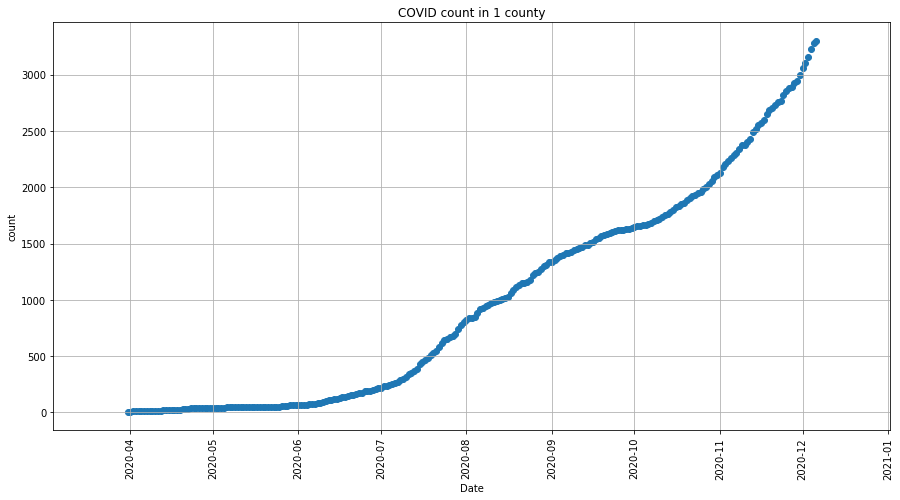

In [49]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(data1['date'], data1['data'])
plt.title('COVID count in 1 county')
plt.ylabel('count')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

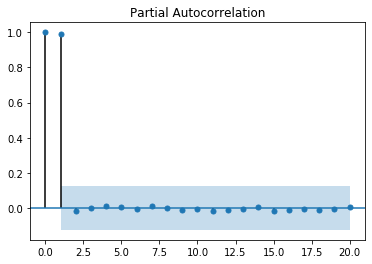

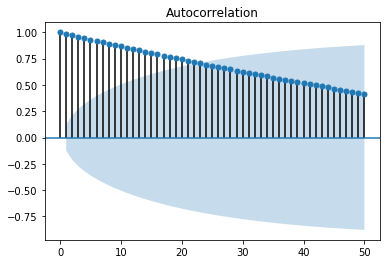

In [56]:
plot_pacf(data1['data'].values,lags=20);
plot_acf(data1['data'].values.astype(float),lags=50);

In [58]:
# Take the log difference to make data stationary
data1['data'] = np.log(data1['data'].values.astype(float))
data1['data'] = data1['data'].diff()
data1 = data1.drop(data1.index[0])
data1.head()

,date,data
1,2020-04-01,0.000000
2,2020-04-02,0.251314
3,2020-04-03,0.200671
4,2020-04-04,0.087011
5,2020-04-05,0.080043


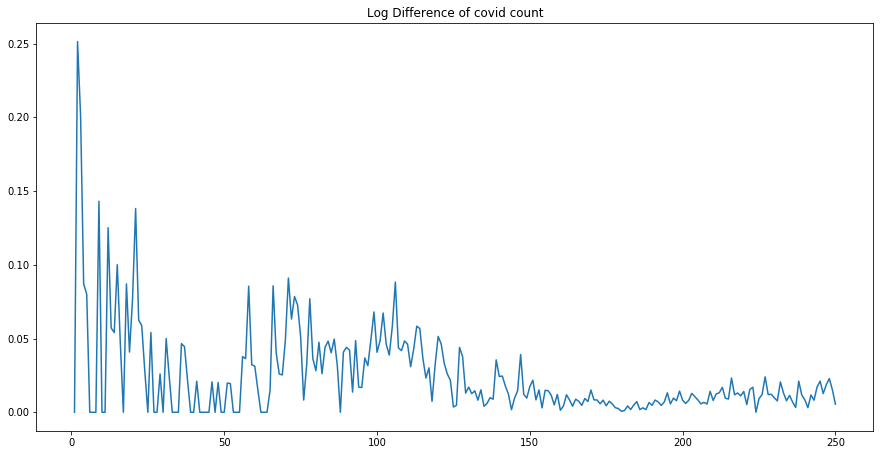

In [60]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data1['data'])
plt.title("Log Difference of covid count")
plt.show()

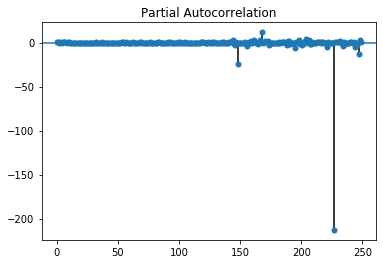

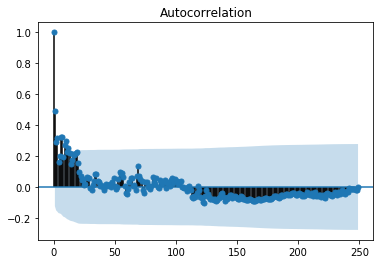

In [61]:
plot_pacf(data1['data']);
plot_acf(data1['data']);

# Akaike’s Information Criterion (AIC)

## useful for selecting the order (p,d,q) of an ARIMA model. The AIC is expressed as:

$ AIC = -2 \log(L) + 2k$

where $L$ is the likelihood of the model and $k$ is the number of parameters

+ relative to other models
+ not a guarantee that the model will have a good performance on unseen data, or that its SSE will be small


In [62]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [65]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = zip(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data1['data'])
result_df.sort_values('AIC')

,"(p, d, q)",AIC
0,"(4, 1, 4)",-1125.165789
1,"(6, 1, 6)",-1121.671292
2,"(2, 1, 2)",-1116.748797
3,"(3, 1, 3)",-1110.724860
4,"(1, 1, 1)",-1104.376051
5,"(0, 1, 0)",-1016.891125


In [66]:
best_model = SARIMAX(data1['data'], order=(0,1,0)).fit()
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                   data   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 509.446
Date:                Mon, 08 Mar 2021   AIC                          -1016.891
Time:                        10:37:18   BIC                          -1013.374
Sample:                             0   HQIC                         -1015.475
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0010   2.63e-05     37.255      0.000       0.001       0.001
Ljung-Box (Q):                       87.93   Jarque-Bera (JB):              4454.57
Prob(Q):                              0.00   Pr

## Model eqn. best inferred:
    
$ p=0, d=1, q=0$

Hence the euqation:

$y_t' =   \epsilon_t  $

which is simply:
$y_{t+1} = y_t + \epsilon_t$

ie teh best model is a random walk.
